09 トピックモデリングと文書クラスタリング
===================================

* テキストデータによく用いられる技術の1つが、`トピックモデリング`

    * これは通常は教師なし学習で、それぞれの文書に対して1つ以上の`トピック`を割り当てるタスクをまとめて呼ぶ言葉
    
    * 例)ニュースなど
    
    * それぞれの文書に1つのトピックが与えられるのであれば、クラスタリングとなる
    
    * それぞれの文書が複数のトピックを持つことができるのであれば、成分分析となる
    
    * 学習した個々の成分がトピックとなり、文書表現のそれぞれの成分に対する係数は、その文書が特定のトピックにどの程度関連するかを表現する事になる
    
* 多くの場合、「トピックモデリング」というと、`LDA`と呼ばれる特定の成分分析手法を指す

## 1. LDA(Latent Dirichlet Allocation)

* `LDA`は、同時に現れる頻度の高い単語の集合(トピック)を指す

    * また、`LDA`はそれぞれの文書が、いくつかのトピックの「混合物」であることを要請する
    
    * 機械学習モデルでいう所の「トピック」が、日常会話で使う「トピック」とは異なることを理解しておく
    
* 機械学習モデルのトピックは、`PCA`や`NMF`の成分に近い

* 映画レビューのデータセットに`LDA`を適用して、実際にどのように動くかを見てみる

    * 教師なしのテキスト文書モデルでは、一般的な単語が解析に影響を与え過ぎないように、一般的な単語を取り除いた方が良いとされる
    
    * ここでは、15%以上の文書に現れる単語を取り除き、それ以外で最もよく現れる10,000単語に限って`BoW`モデルを構築した

In [1]:
from sklearn.datasets import load_files

reviews_train = load_files("/Users/MacUser/data/aclImdb/train/")
text_train, y_train = reviews_train.data, reviews_train.target
text_train = [doc.replace(b"<br />", b" ") for doc in text_train]
reviews_test = load_files("/Users/MacUser/data/aclImdb/test/")
text_test, y_test = reviews_test.data, reviews_test.target
text_test = [doc.replace(b"<br />", b" ") for doc in text_test]

from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer().fit(text_train)
X_train = vect.transform(text_train)

import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
scores = cross_val_score(LogisticRegression(), X_train, y_train, cv=5)

from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid.fit(X_train, y_train)

X_test = vect.transform(text_test)

vect = CountVectorizer(min_df=5).fit(text_train)
X_train = vect.transform(text_train)
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid.fit(X_train, y_train)

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
pipe = make_pipeline(TfidfVectorizer(min_df=5, norm=None),
                     LogisticRegression())
param_grid = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10]}

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(text_train, y_train)

vectorizer = grid.best_estimator_.named_steps["tfidfvectorizer"]
# 訓練データセットを変換
X_train = vectorizer.transform(text_train)
# それぞれの特徴量のデータセット中での最大値を見つける
max_value = X_train.max(axis=0).toarray().ravel()
sorted_by_tfidf = max_value.argsort()
# 特徴量名を取得
feature_names = np.array(vectorizer.get_feature_names())
sorted_by_idf = np.argsort(vectorizer.idf_)

/Users/MacUser/anaconda2/envs/tf140/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/MacUser/anaconda2/envs/tf140/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/MacUser/anaconda2/envs/tf140/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/MacUser/anaconda2/envs/tf140/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [2]:
vect = CountVectorizer(max_features=10000, max_df=.15)
X = vect.fit_transform(text_train)

* まずは、10トピックでトピックモデルを作ってみる

    * `NMF`の成分と同様に、トピックには順番がないので、トピックの数を変更すると、全てのトピックが変更されてしまう
    
    * ここではデフォルトの"online"ではなく、"batch"を用いる(結果がよくなるが、遅い)
    
    * また、"max_iter"を大きい値に指定している

In [3]:
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_topics=10, learning_method="batch",
                                max_iter=25, random_state=0)
# ここではモデルの構築と変換を一度に行う
# 変換には時間がかかるが、同時に行うことで、時間を節約することができる
document_topics = lda.fit_transform(X)

/Users/MacUser/anaconda2/envs/tf140/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


* 成分分析手法と同様に、`LatentDirichletAllocation`には、それぞれの単語のそのトピックに対する重要性を格納した`components_`属性がある

    * `components_`のサイズは、`(n_topics, n_words)`である

In [4]:
print("lda.components_.shape: {}".format(lda.components_.shape))

lda.components_.shape: (10, 10000)


* トピックの意味を理解するために、それぞれのトピックについて最も重要な単語を見てみる

    * `print_topics`関数を使うと、これらの特徴量を綺麗に表示してくれる

In [5]:
# それぞれのトピック(components_の行)に対して、特徴量を昇順でソート
# ソートを降順にするために、[:, ::-1]で行を反転
sorting = np.argsort(lda.components_, axis=1)[:, ::-1]
# vectorizerから特徴量名を取得
feature_names = np.array(vect.get_feature_names())

In [6]:
import mglearn
# 最初の10トピックを表示
mglearn.tools.print_topics(topics=range(10), feature_names=feature_names,
                           sorting=sorting, topics_per_chunk=5, n_words=10)

topic 0       topic 1       topic 2       topic 3       topic 4       
--------      --------      --------      --------      --------      
between       war           funny         show          didn          
young         world         worst         series        saw           
family        us            comedy        episode       am            
real          our           thing         tv            thought       
performance   american      guy           episodes      years         
beautiful     documentary   re            shows         book          
work          history       stupid        season        watched       
each          new           actually      new           now           
both          own           nothing       television    dvd           
director      point         want          years         got           


topic 5       topic 6       topic 7       topic 8       topic 9       
--------      --------      --------      --------      --------      
horr

* 重要な単語から判断すると、トピック1は歴史ものの戦争映画、トピック2はつまらないコメディ、トピック3はTVシリーズなど

* 次に100トピックでモデルを作ってみる

    * トピックが多くなると解析は大変になるが、興味深いデータセットに特化したトピックとなるはず

In [7]:
lda100 = LatentDirichletAllocation(n_topics=100, learning_method="batch",
                                   max_iter=25, random_state=0)
document_topics100 = lda100.fit_transform(X)

/Users/MacUser/anaconda2/envs/tf140/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


* 100トピックを全てみるのは大変なので、面白そうなトピックを選んだ

In [8]:
topics = np.array([7, 16, 24, 25, 28, 36, 37, 41, 45, 51, 53, 54, 63, 89, 97])

In [9]:
sorting = np.argsort(lda100.components_, axis=1)[:, ::-1]
feature_names = np.array(vect.get_feature_names())
mglearn.tools.print_topics(topics=topics, feature_names=feature_names,
                           sorting=sorting, topics_per_chunk=5, n_words=20)

topic 7       topic 16      topic 24      topic 25      topic 28      
--------      --------      --------      --------      --------      
thriller      worst         german        car           beautiful     
suspense      awful         hitler        gets          young         
horror        boring        nazi          guy           old           
atmosphere    horrible      midnight      around        romantic      
mystery       stupid        joe           down          between       
house         thing         germany       kill          romance       
director      terrible      years         goes          wonderful     
quite         script        history       killed        heart         
bit           nothing       new           going         feel          
de            worse         modesty       house         year          
performances  waste         cowboy        away          each          
dark          pretty        jewish        head          french        
twist 

* 今度のトピックははるかに具体的になっているが、その多くは解釈が難しいものとなっている

    * 例)トピック45は音楽に関連するもの(このトピックに分類されたレビューを見てみる)

In [10]:
# "音楽関連"トピック45に対する重みでソート
music = np.argsort(document_topics100[:, 45])[::-1]
# このトピックを最も重要としている5つの文書を表示
for i in music[:10]:
    # 最初の2文を表示
    print(b".".join(text_train[i].split(b".")[:2]) + b".\n")

b'I love this movie and never get tired of watching. The music in it is great.\n'
b"I enjoyed Still Crazy more than any film I have seen in years. A successful band from the 70's decide to give it another try.\n"
b'Hollywood Hotel was the last movie musical that Busby Berkeley directed for Warner Bros. His directing style had changed or evolved to the point that this film does not contain his signature overhead shots or huge production numbers with thousands of extras.\n'
b"What happens to washed up rock-n-roll stars in the late 1990's? They launch a comeback / reunion tour. At least, that's what the members of Strange Fruit, a (fictional) 70's stadium rock group do.\n"
b'As a big-time Prince fan of the last three to four years, I really can\'t believe I\'ve only just got round to watching "Purple Rain". The brand new 2-disc anniversary Special Edition led me to buy it.\n'
b"This film is worth seeing alone for Jared Harris' outstanding portrayal of John Lennon. It doesn't matter that H

* この結果から分かるように、このトピックはミュージカルから伝記映画など、様々な音楽を取り上げたレビューをカバーしている

* トピックを調べるもう1つの方法として、それぞれのトピックが全文書に対して得た重みを見てみる

    * それぞれのトピックに、最も一般的な2つの単語で名前をつけている
    
    * 以下の図に、学習されたトピックの重みを示す

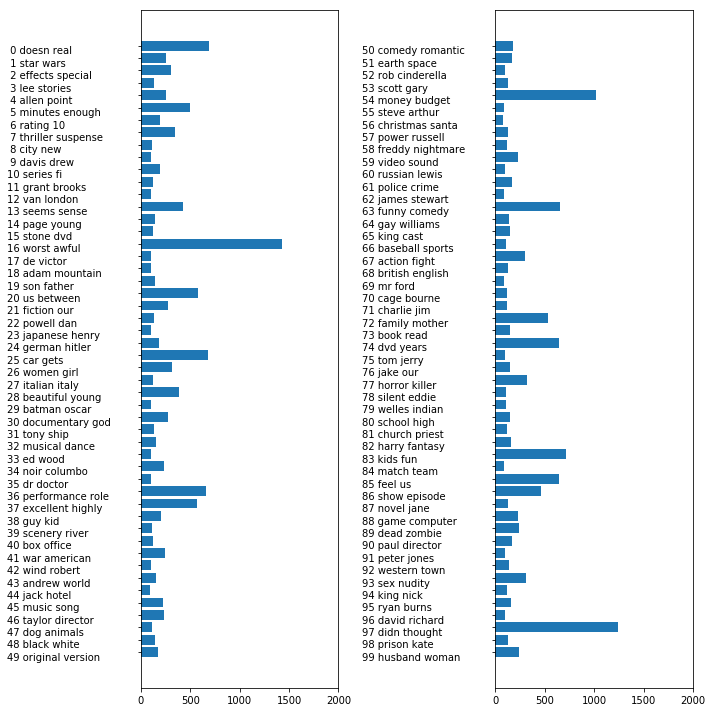

In [11]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 10))
topic_names = ["{:>2} ".format(i) + " ".join(words)
               for i, words in enumerate(feature_names[sorting[:, :2]])]
# 2カラムの棒グラフ
for col in [0, 1]:
    start = col * 50
    end = (col + 1) * 50
    ax[col].barh(np.arange(50), np.sum(document_topics100, axis=0)[start:end])
    ax[col].set_yticks(np.arange(50))
    ax[col].set_yticklabels(topic_names[start:end], ha="left", va="top")
    ax[col].invert_yaxis()
    ax[col].set_xlim(0, 2000)
    yax = ax[col].get_yaxis()
    yax.set_tick_params(pad=130)
plt.tight_layout()

* 最も重要なトピックは、否定的な評価に対応していると思われる70、ストップワードを含む16、13、58、肯定的な評価に関連する86

    * 86の「10」は10段階評価の10：コメントの中に出てきている

* `LDA`はおおまかに分けて、ジャンルに固有なトピックと、評価に固有なトピック、それ以外の特定しづらいトピックを見つけているようにみえる

    * 多くのレビューは映画固有のコメントと評価を正当化するようなコメントで構成されているので、興味深い

* `LDA`のようなトピックモデルは、ラベルがない大規模なテキストコーパスを理解する興味深い方法である

    * ここで行なったように、ラベルがある場合にも有用
    
    * ただし、LDAアルゴリズムはランダムなので、`random_state`パラメータを変えると全く違った結果になる場合がある
    
* トピックを特定することは重要だが、教師なし学習モデルから導かれた結果は全て、まゆに唾を付けて見る必要がある

    * 個々のトピックの文書を実際に見て直感が正しいかを確認することをオススメする
    
    * `LDA.transform`メソッドで作られたトピック群を教師あり学習のためのコンパクトなデータ表現とみなすこともできる
    
    * この方法は、ラベルのある訓練データが十分にない場合に、特に有効

| 版   | 年/月/日   |
| ---- | ---------- |
| 初版 | 2019/04/06 |